In [1]:
#run preprocessing script to make objects available

%run PreProcessing.ipynb

Current Progress: 100.0 %


In [2]:
#import required libraries

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import *
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Encode categoriccal variables that will be used as predictors

enc = OrdinalEncoder()
encoded_df = enc.fit_transform(summary_data_avg[['method', 'variety', 'inputs', 'protection']])
summary_data_avg[['method', 'variety', 'inputs', 'protection']] = encoded_df.copy()

In [4]:
# Assign 'X' and 'y' values and split into seperate train and test df.

X = summary_data_avg[['heat_units', 'solar_radiation', 'organic_matter', 'sand', 'silt', 'clay', 'method', 'variety', 'inputs', 'protection']]
y = summary_data_avg['mean_diameter']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)
X.head()

,heat_units,solar_radiation,organic_matter,sand,silt,clay,method,variety,inputs,protection
0,1970,1073585,24.6,40,41,19,2.0,11.0,1.0,0.0
1,2641,1247965,24.6,40,41,19,2.0,11.0,1.0,0.0
2,3189,1379555,24.6,40,41,19,2.0,11.0,1.0,0.0
3,3540,1529793,24.6,40,41,19,2.0,11.0,1.0,0.0
4,3813,1631446,24.6,40,41,19,2.0,11.0,1.0,0.0


In [5]:
# Use the isolation forest algorithm to remove the most rogue 10% of datapoints.
# Check only 10% was removed.

print(f"The old training dataframe shape: {X_train.shape}")

clf1 = IsolationForest(max_samples=500, random_state = 10, contamination= 0.1)
preds = clf1.fit_predict(X_train)

totalOutliers=0
for pred in preds:
    if pred == -1:
        totalOutliers=totalOutliers+1
print("Total number of outliers identified is: ",totalOutliers)

The old training dataframe shape: (2690, 10)
Total number of outliers identified is:  269


In [6]:
# Remove outliers from training data.
# Do not remove from test data as this is bad practice.
# Confirm removal by checking new df shape.

filtered_array = []
for element in preds:
  if element != -1:
    filtered_array.append(True)
  else:
    filtered_array.append(False)
X_train = X_train[filtered_array]
y_train = y_train[filtered_array]

print(f"The new training dataframe shape: {X_train.shape}")

The new training dataframe shape: (2421, 10)


In [7]:
# Scaled data although there is no need to scale with a Random Forest algorithm.
# Only fit the scaled data using the training df but use it to transform both test and train.
# This data won't be used but this is necessary for a lot of other ML algorithms.
# Keep here as a reminder in case another model is developed.

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [8]:
# Hypertuning model to find best parameters.
# Print the best parameters to use within the model.

param_grid = {'random_state': [10],
              'max_features': ['sqrt', 'auto', 'log2'],
              'bootstrap': [True, False]}  
   
grid_rfr = GridSearchCV(RandomForestRegressor(), param_grid, refit = True, verbose = 3, n_jobs= 2)

grid_rfr.fit(X_train, y_train.values.ravel()) 
 
print(grid_rfr.best_params_)   

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'bootstrap': True, 'max_features': 'sqrt', 'random_state': 10}


In [9]:
# Fit hypertuned model and print score.

rfr = RandomForestRegressor(max_features = 'sqrt', random_state = 10, n_estimators = 50, max_depth = 10)
rfr_model = rfr.fit(X_train, y_train.values.ravel())
rfr_model_pred = rfr_model.predict(X_test)
print(rfr.score(X_test, y_test))

0.8884269866990918


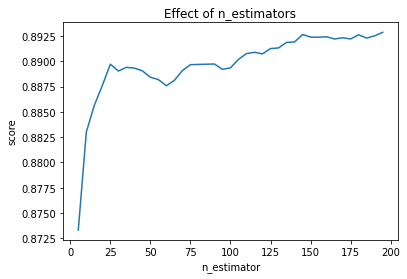

In [10]:
# Optimisation for n_estimators parameter.

estimators = np.arange(5, 200, 5)
scores = []
for n in estimators:
    rfr.set_params(n_estimators=n)
    rfr.fit(X_train, y_train)
    scores.append(rfr.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

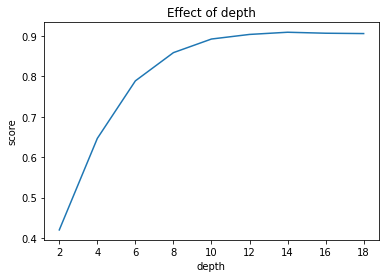

In [11]:
# Optimisation for max_depth parameter.

depth = np.arange(2, 20, 2)
scores = []
for n in depth:
    rfr.set_params(max_depth=n)
    rfr.fit(X_train, y_train)
    scores.append(rfr.score(X_test, y_test))
plt.title("Effect of depth")
plt.xlabel("depth")
plt.ylabel("score")
plt.plot(depth, scores)

In [12]:
# Join 'X' and 'y' test df together along with predictions to make visualisations easier.

y_test_df = y_test.to_frame()
y_test_df = y_test_df.rename(columns = {0:'mean_diameter'}).reset_index(drop=True)

pred_df = pd.DataFrame(rfr_model_pred, columns = ['predicted_mean_diameter']).reset_index(drop=True)
X_test_df = pd.DataFrame(X_test, columns = ['heat_units', 'solar_radiation', 'organic_matter', 'sand', 'silt', 'clay', 'method', 'variety', 'inputs', 'protection']).reset_index(drop = True)

test_df = X_test_df.copy()
test_df['predicted_mean_diameter'] = pd.Series(pred_df['predicted_mean_diameter'])
test_df['mean_diameter'] = pd.Series(y_test_df['mean_diameter'])

test_df[['method', 'variety', 'inputs', 'protection']] = enc.inverse_transform(test_df[['method',
                                                                                        'variety',
                                                                                        'inputs',
                                                                                        'protection']])

test_df.head()

,heat_units,solar_radiation,organic_matter,sand,silt,clay,method,variety,inputs,protection,predicted_mean_diameter,mean_diameter
0,4089,1771489,29.6,39,37,24,Drilled,Batter,Conventional,Barley,28.052743,26.919200
1,3531,1425903,69.8,38,52,10,Drilled,Chiefton,Conventional,Barley,25.735144,30.121481
2,2328,1293708,43.3,36,42,22,Drilled,Spheros,Conventional,Barley,15.327111,13.330213
3,3365,1537170,20.0,63,15,22,Drilled,Linkton,Conventional,Barley,24.691139,23.685106
4,3958,1586370,19.9,31,36,33,Drilled,Lexton,Conventional,Barley,26.792704,24.416800


In [13]:
test_df.shape

(673, 12)

<AxesSubplot:xlabel='predicted_mean_diameter', ylabel='mean_diameter'>

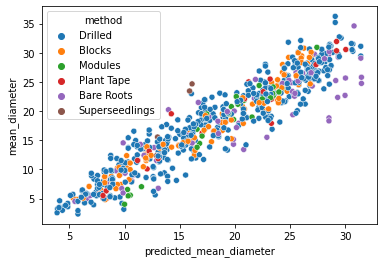

In [14]:
# Scatterplot to show how predicted mean compares to actual mean.
# Set hue to see if any indicator variables have a bias.

sns.scatterplot(y = 'mean_diameter', x = 'predicted_mean_diameter', hue = 'method', data = test_df)

<AxesSubplot:xlabel='solar_radiation', ylabel='predicted_mean_diameter'>

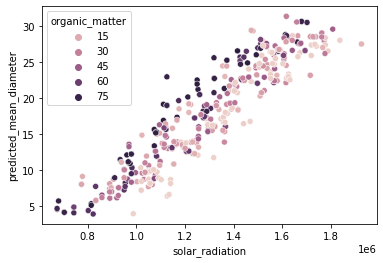

In [15]:
# Scatterplot to show how organic matter affects predicted growth rate.

sns.scatterplot(y = 'predicted_mean_diameter', x = 'solar_radiation', hue = 'organic_matter', data = test_df[(test_df.method == 'Drilled')])

In [16]:
summary_data_avg.head()

,fieldzonedate,mean_diameter,std_dev_diameter,pp2m2,skewness,kurtosis,method,inputs,variety,sand,silt,clay,organic_matter,planting_rate,planting_date,sample_date,fieldzone,d_lin,s_lin,heat_units,solar_radiation,protection,protection_Barley,protection_Fleece,protection_None,protection_Poly
0,Allans 06 - 1 - 2021-07-29,9.175789,3.043690,38,0.222939,-0.418881,2.0,1.0,11.0,40,41,19,24.6,262270,2021-04-10,2021-07-29,Allans 06 - 1,3.996245,2.005050,1970,1073585,0.0,1,0,0,0
1,Allans 06 - 1 - 2021-08-18,17.076098,4.068069,41,-0.039656,-0.908057,2.0,1.0,11.0,40,41,19,24.6,262270,2021-04-10,2021-08-18,Allans 06 - 1,5.891731,2.403630,2641,1247965,0.0,1,0,0,0
2,Allans 06 - 1 - 2021-09-07,19.612727,6.276772,44,-0.580590,0.029431,2.0,1.0,11.0,40,41,19,24.6,262270,2021-04-10,2021-09-07,Allans 06 - 1,6.424454,3.151993,3189,1379555,0.0,1,0,0,0
3,Allans 06 - 1 - 2021-10-05,26.536889,7.682152,45,-1.109977,0.722065,2.0,1.0,11.0,40,41,19,24.6,262270,2021-04-10,2021-10-05,Allans 06 - 1,7.760796,3.576241,3540,1529793,0.0,1,0,0,0
4,Allans 06 - 1 - 2021-11-12,27.324000,8.001953,40,0.199289,0.418831,2.0,1.0,11.0,40,41,19,24.6,262270,2021-04-10,2021-11-12,Allans 06 - 1,7.903877,3.668576,3813,1631446,0.0,1,0,0,0


In [18]:
establishment_df = summary_data_avg[['fieldzonedate', 'pp2m2', 'planting_rate', 'planting_date']].copy()
establishment_df.head()

,fieldzonedate,pp2m2,planting_rate
0,Allans 06 - 1 - 2021-07-29,38,262270
1,Allans 06 - 1 - 2021-08-18,41,262270
2,Allans 06 - 1 - 2021-09-07,44,262270
3,Allans 06 - 1 - 2021-10-05,45,262270
4,Allans 06 - 1 - 2021-11-12,40,262270


In [41]:
estab_df = pd.DataFrame(summary_data_avg.fieldzonedate.str.split(pat=' - ', n= -1,).tolist(), columns="field zone date".split())
estab_df[['pp2m2', 'planting_rate', 'planting_date']] = summary_data_avg[['pp2m2', 'planting_rate', 'planting_date']].copy()
estab_df = estab_df.drop('date', axis = 1)
estab_df['fieldzone'] = estab_df['field'] + ' - ' + estab_df['zone']
estab_df = estab_df.groupby(['fieldzone']).agg({'pp2m2' : ['mean', 'std'],
                                                'planting_rate' : 'mean',
                                                'planting_date' : 'first'}).reset_index()

estab_df.columns = ['fieldzone', 'mean_pp2m2', 'std_pp2m2', 'planting_rate', 'planting_date']

estab_df['establishment'] = 

estab_df.head()

,fieldzone,mean_pp2m2,std_pp2m2,planting_rate,planting_date
0,Allans 06 - 1,41.6,2.880972,262270,2021-04-10
1,Allans 06 - 2,42.8,2.683282,262270,2021-04-10
2,Allans 06 - 3,44.0,4.949747,262270,2021-04-10
3,Allans 06 - 4,36.2,3.114482,259048,2021-04-11
4,Allans 06 - 5,40.8,3.633180,259048,2021-04-11
